In [24]:
import os
import numpy as np
from glob import glob
from skimage.io import imread
from cellpose import models
from tqdm import tqdm

#image_dir = "/storage01/miroslavm/3d_segmentation_models/data_rat/cellpose_png/test"
image_dir = "/NAS/mmaiurov/Datasets/Hela_MRC_cellpose/test"
mask_filter = "_cp_masks.png"

image_files = sorted([f for f in glob(os.path.join(image_dir, "*.png")) if not f.endswith(mask_filter)])
mask_files = sorted([f for f in glob(os.path.join(image_dir, f"*{mask_filter}"))])

pairs = [(img, msk) for img, msk in zip(image_files, mask_files)
         if os.path.basename(img).replace(".png", "") == os.path.basename(msk).replace(mask_filter, "")]

#model_path = "/storage01/miroslavm/3d_segmentation_models/data_rat/cellpose_png/train/models/rat_cellpose_model_resume2"
model_path = "/NAS/mmaiurov/Datasets/Hela_MRC_cellpose/train/models/hela_mrc"
model = models.CellposeModel(gpu=True, pretrained_model=model_path)

In [11]:
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

def compute_instance_dice(gt, pred, iou_thresh=0.5):
    gt_labels = np.unique(gt)
    pred_labels = np.unique(pred)
    gt_labels = gt_labels[gt_labels != 0]
    pred_labels = pred_labels[pred_labels != 0]

    matched_gt = set()
    matched_pred = set()

    for g in gt_labels:
        g_mask = gt == g
        for p in pred_labels:
            if p in matched_pred:
                continue
            p_mask = pred == p
            iou = compute_iou(g_mask, p_mask)
            if iou >= iou_thresh:
                matched_gt.add(g)
                matched_pred.add(p)
                break

    TP = len(matched_gt)
    FP = len(pred_labels) - len(matched_pred)
    FN = len(gt_labels) - len(matched_gt)

    return (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0.0
dice_scores = []
for img_path, mask_path in tqdm(pairs):
    img = imread(img_path)
    gt_mask = imread(mask_path)

    pred_mask, _, _ = model.eval([img], channels=[0, 0])
    pred_mask = pred_mask[0]

    dice = compute_instance_dice(gt_mask, pred_mask, iou_thresh=0.5)
    print(dice)
    if dice !=0.0:
        dice_scores.append(dice)

print("Mean Dice:", np.mean(dice_scores))

  2%|█▎                                                              | 1/48 [00:00<00:30,  1.55it/s]

0.0


  4%|██▋                                                             | 2/48 [00:01<00:28,  1.59it/s]

0.0


  6%|████                                                            | 3/48 [00:01<00:28,  1.60it/s]

0.0


  8%|█████▎                                                          | 4/48 [00:03<00:42,  1.03it/s]

0.5


 10%|██████▋                                                         | 5/48 [00:04<00:49,  1.16s/it]

0.7142857142857143


 12%|████████                                                        | 6/48 [00:06<00:54,  1.30s/it]

0.7692307692307693


 15%|█████████▎                                                      | 7/48 [00:08<01:04,  1.56s/it]

0.7727272727272727


 17%|██████████▋                                                     | 8/48 [00:10<01:09,  1.75s/it]

0.7450980392156863


 19%|████████████                                                    | 9/48 [00:13<01:24,  2.17s/it]

0.696969696969697


 21%|█████████████▏                                                 | 10/48 [00:18<01:48,  2.85s/it]

0.7777777777777778


 23%|██████████████▍                                                | 11/48 [00:22<02:06,  3.43s/it]

0.7111111111111111


 25%|███████████████▊                                               | 12/48 [00:27<02:14,  3.73s/it]

0.74


 27%|█████████████████                                              | 13/48 [00:34<02:41,  4.62s/it]

0.704


 29%|██████████████████▍                                            | 14/48 [00:42<03:13,  5.68s/it]

0.7482014388489209


 31%|███████████████████▋                                           | 15/48 [00:52<03:56,  7.17s/it]

0.7


 33%|█████████████████████                                          | 16/48 [01:00<03:58,  7.45s/it]

0.8029197080291971


 35%|██████████████████████▎                                        | 17/48 [01:13<04:37,  8.97s/it]

0.7044025157232704


 38%|███████████████████████▋                                       | 18/48 [01:23<04:44,  9.47s/it]

0.7295597484276729


 38%|███████████████████████▋                                       | 18/48 [01:27<02:25,  4.85s/it]


KeyboardInterrupt: 

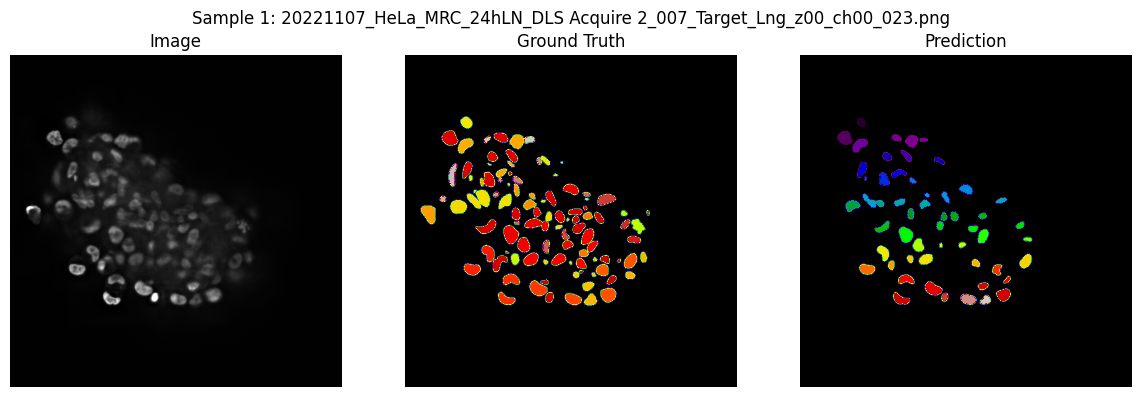

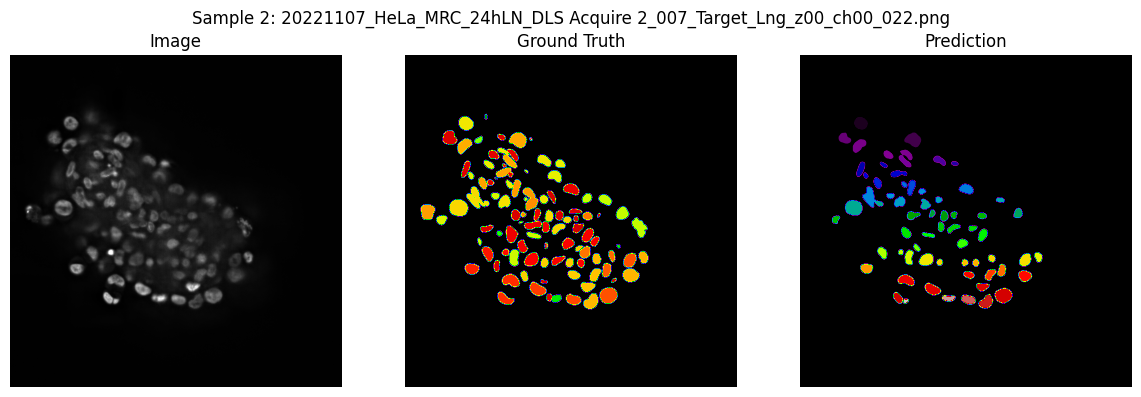

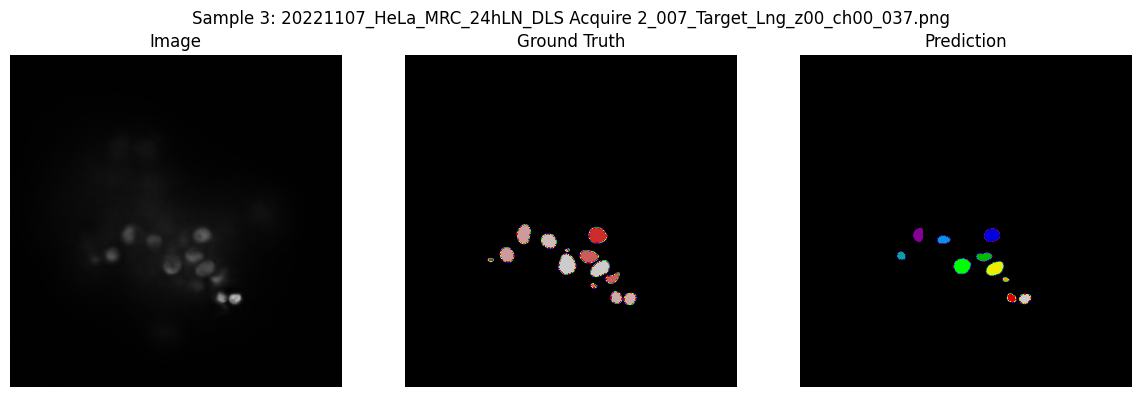

In [21]:
import random
import matplotlib.pyplot as plt
sampled = random.sample(pairs, 3)
for i, (img_path, mask_path) in enumerate(sampled):
    img = imread(img_path)
    gt_mask = imread(mask_path)
    pred_mask, _, _ = model.eval([img], channels=[0, 0])
    pred_mask = pred_mask[0]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask, cmap='nipy_spectral')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='nipy_spectral')
    plt.title("Prediction")
    plt.axis('off')

    plt.suptitle(f"Sample {i+1}: {os.path.basename(img_path)}")
    plt.tight_layout()
    plt.show()

In [25]:
from skimage.measure import label
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

def compute_instance_metrics(gt, pred, iou_thresh=0.5):
    gt_labels = np.unique(gt)
    pred_labels = np.unique(pred)
    gt_labels = gt_labels[gt_labels != 0]
    pred_labels = pred_labels[pred_labels != 0]

    matched_gt = set()
    matched_pred = set()

    for g in gt_labels:
        g_mask = gt == g
        for p in pred_labels:
            if p in matched_pred:
                continue
            p_mask = pred == p
            iou = compute_iou(g_mask, p_mask)
            if iou >= iou_thresh:
                matched_gt.add(g)
                matched_pred.add(p)
                break

    TP = len(matched_gt)
    FP = len(pred_labels) - len(matched_pred)
    FN = len(gt_labels) - len(matched_gt)

    f1 = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0.0
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)

    return f1, precision, recall, TP, FP, FN

def compute_pixelwise_dice(gt, pred):
    gt_bin = gt > 0
    pred_bin = pred > 0
    intersection = np.logical_and(gt_bin, pred_bin).sum()
    volume_sum = gt_bin.sum() + pred_bin.sum()
    return (2 * intersection) / volume_sum if volume_sum > 0 else 1.0

# ───────────────────── Evaluation ─────────────────────
f1_scores = []
precisions = []
recalls = []
pixel_dices = []

for img_path, mask_path in tqdm(pairs):
    img = imread(img_path)
    gt_mask = imread(mask_path)
    gt_mask = label(gt_mask)

    pred_mask, _, _ = model.eval([img], channels=[0, 0])
    pred_mask = pred_mask[0]

    f1, prec, rec, tp, fp, fn = compute_instance_metrics(gt_mask, pred_mask)
    dice_px = compute_pixelwise_dice(gt_mask, pred_mask)

    f1_scores.append(f1)
    precisions.append(prec)
    recalls.append(rec)
    pixel_dices.append(dice_px)

print("\n==== Evaluation Summary ====")
print(f"Mean Instance Dice (F1) : {np.mean(f1_scores):.4f}")
print(f"Mean Pixelwise Dice     : {np.mean(pixel_dices):.4f}")
print(f"Mean Precision          : {np.mean(precisions):.4f}")
print(f"Mean Recall             : {np.mean(recalls):.4f}")

100%|███████████████████████████████████████████████████████████████| 48/48 [03:20<00:00,  4.17s/it]


==== Evaluation Summary ====
Mean Instance Dice (F1) : 0.5339
Mean Pixelwise Dice     : 0.7461
Mean Precision          : 0.6695
Mean Recall             : 0.4493
